# Imports

In [2]:
# import stuff
import os, sys, time, json, csv, math, difflib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tifffile as tif
from scipy.ndimage.interpolation import zoom

In [3]:
import warnings
warnings.simplefilter('ignore')

# User Inputs

In [4]:
# load label csvs 
labels_dir = '/Users/emilydennis/Desktop/labels/'
lab_sigma = pd.read_csv(os.path.join(labels_dir,'sigma_labels.csv'))
lab_whs = pd.read_csv(os.path.join(labels_dir,'whs_with_parents.csv'))
lab_pma = pd.read_csv(os.path.join(labels_dir,'PMA_ann.csv'))
syns = pd.read_csv(os.path.join(labels_dir,'syns_with_parents.csv'))
PRAlabs = pd.read_csv(os.path.join(labels_dir,'PRA_labels_with-graph-order_children_parents.csv')).drop(columns=['Unnamed: 0'])

# load json
with open(os.path.join(labels_dir,'PRA_ontology.json')) as f:
  ontology = json.load(f)

In [109]:
# get all dissimilarity values for each overlapping set in two labeled volumes
def get_dissimilarity(Alab,Aval,Blab,Bval):
    nameA = get_name(Alab,Aval)
    print(nameA)
    familytreeA = get_hierarchy(Alab,nameA)
    nameB = get_name(Blab,Bval)
    print(nameB)
    familytreeB = get_hierarchy(Blab,nameB)
    if len(familytreeA) > len(familytreeB):
        # if family tree A longer than B
        diss = get_diss_value(familytreeA,familytreeB)
    elif len(familytreeB) > len(familytreeA):
        diss = get_diss_value(familytreeB,familytreeA)
    else:
        da = get_diss_value(familytreeA,familytreeB)
        db = get_diss_value(familytreeB,familytreeA)
        diss = min(da,db)
    return diss


# Define Functions

In [5]:
def reformat(str_in):
    if isinstance(str_in,str):
        if str_in[-1]== ' ':
            str_in = str_in[:-1]
        str_in = str_in.replace(" ","_")
        str_in = str_in.replace("/","_")
        str_in = str_in.replace(",","")
        str_out = str_in.lower()
    else:
        print('{} is not a string'.format(str_in))
    return str_out

In [7]:
def replace_with_common_name(pd_in,syns):
    pd_out = pd_in.copy()
    for i in np.arange(0,len(pd_out.name)):
        lab = pd_out.name[i]
        if isinstance(lab,str):
            lab = reformat(lab)
            if (syns.name == lab).any(): 
                pd_out.name[i]=check_for_syn(lab,syns)
    return pd_out

In [6]:
def check_for_syn(name,syns):
    if name in list(syns.name):
        synonymns = syns[syns.name==name]['common_name']
    else: 
        synonymns=[]
    return synonymns

In [8]:
# get the parent name of a given name/volume
def get_parent_id_from_praid(labeledvolume,praid):
    parentid=list(labeledvolume.loc[labeledvolume.id == praid,'parent_id'])[0]
    return parentid

In [9]:
# get the hierarchy/family tree of a given name in a given volume
def get_hierarchy(labeledvolume,praid,maxlen):
    familytree = []
    parentid = get_parent_id_from_praid(labeledvolume,praid)
    # if parent isn't root, look for grandparent
    while parentid > 0:
        # add parent/grandparent... to tree
        familytree.append(parentid)
        # get grandparent/great grandparent...
        parentid=get_parent_id_from_praid(labeledvolume,parentid)
    familytree.reverse()
    print('family tree was {}'.format(familytree))
    if len(familytree) < 1:
        familytree=0
    return familytree   

# 2021.04.10 example of how to take a labeled volume and relate to PRA

In [11]:
lab_sigma.insert(3,'name','null')
lab_sigma.insert(4,'common_name','null')
lab_sigma

In [174]:
manual_check=[]

for i in lab_sigma.index:
    print(i)
    lab_sigma.at[i,'name']=reformat(lab_sigma.label[i])
    nm=lab_sigma.at[i,'name']
    if nm in list(syns.common_name):
        lab_sigma.at[i,'common_name']=nm
    elif nm in list(syns.name):
        lab_sigma.at[i,'common_name']=list(syns.common_name[syns.name==nm])[0]
    else:
        manual_check.append(i)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181


In [175]:
manual_check

[141]

In [176]:
# for each element of manual_check, we print the name, and closest options
idval=141
print(list(lab_sigma[lab_sigma.index==idval]['name'])[0])
difflib.get_close_matches(list(lab_sigma[lab_sigma.index==idval]['name'])[0],syns.name,20)

anterior_commissure_intrabulbar_part


['anterior_commissure_intraolfactory_bulbar_part',
 'anterior_commissure_anterior_part',
 'anterior_commissure_posterior_part',
 'anterior_commissure_temporal_limb',
 'anterior_commissure,_temporal_limb',
 'anterior_commissure',
 'anterior_commissure',
 'anterior_commissure',
 'anterior_commissure_posterior_limb',
 'anterior_hypothalamic_area_central_part',
 'anterior_cingulate_area_ventral_part',
 'anterior_cingulate_area_ventral_part',
 'anterior_cingulate_area,_ventral_part',
 'anterior_commissure_olfactory_limb',
 'anterior_commissure,_olfactory_limb',
 'anterior_cingulate_area_ventral_part_6b',
 'anterior_cingulate_area_ventral_part_6b',
 'anterior_cingulate_area_ventral_part_6a',
 'anterior_cingulate_area_ventral_part_6a',
 'anterior_olfactory_area_ventral_part']

In [177]:
# change these values for your volume: these correspond to best matches for indices 6,7,141 in lab_sigma
#nms=['amygdalopiriform_transition_area','amygdalopiriform_transition_area','anterior_commissure_intraolfactory_bulbar_part']
nms =['anterior_commissure_intraolfactory_bulbar_part']

In [178]:
# once you've set nms, run this cell to fill in manual_checks with manually chosen values
index=0
for i in manual_check:
    nm = nms[index]
    lab_sigma.at[i,'common_name']=list(syns.common_name[syns.name==nm])[0]
    index+=1

In [179]:
# great! now we have common_names
# now we have common_names that match our PRA ID info. Merge that info into your volume labels.
lab_sigma=lab_sigma.assign(parent_id=np.nan, graph_order=0.0, children='null', has_children=0,parent_ids='null')

In [180]:
lab_sigma #make sure everything makes sense and looks reasonable

,atlas,ID,label,name,common_name,parent_id,graph_order,children,has_children,parent_ids
0,Tohoku,11,Agranular Dysgranular Insular Cortex,agranular_dysgranular_insular_cortex,insular_cortex,NaN,0.0,null,0,null
1,Tohoku,12,Agranular Dysgranular Insular Cortex,agranular_dysgranular_insular_cortex,insular_cortex,NaN,0.0,null,0,null
2,Tohoku,21,Agranular Insular Cortex,agranular_insular_cortex,agranular_insular_cortex,NaN,0.0,null,0,null
3,Tohoku,22,Agranular Insular Cortex,agranular_insular_cortex,agranular_insular_cortex,NaN,0.0,null,0,null
4,Tohoku,31,Amygdalohyppocampic Area,amygdalohyppocampic_area,amygdalohippocampal_cortex,NaN,0.0,null,0,null
...,...,...,...,...,...,...,...,...,...,...
177,Waxholm,1132,Thalamus,thalamus,thalamus,NaN,0.0,null,0,null
178,Waxholm,1141,Brachium Pontis,brachium_pontis,cerebellar_peduncles,NaN,0.0,null,0,null
179,Waxholm,1142,Brachium Pontis,brachium_pontis,cerebellar_peduncles,NaN,0.0,null,0,null
180,Waxholm,1161,Periventricular Grey,periventricular_grey,periventricular_region,NaN,0.0,null,0,null


In [181]:
PRAlabs

,id,name,parent_id,graph_order,children,has_children,parent_ids
0,35,brainstem,0,1,"[39, 40, 41, 577, 595, 189, 190, 265, 266, 267...",1,0
1,36,cerebellum,0,1,"[43, 51, 52, 53, 54, 55, 127, 128, 129, 184, 1...",1,0
2,37,cerebrum,0,1,"[59, 63, 64, 65, 66, 67, 398, 564, 565, 567, 5...",1,0
3,243,corpus_collosum,0,1,[],0,0
4,244,corticospinal_tract,0,1,"[112, 113, 114, 115]",1,0
...,...,...,...,...,...,...,...
612,475,accumbens_nucleus,607,6,[],0,"[37, 66, 34, 61, 607]"
613,476,olfactory_tubercle,607,6,[],0,"[37, 66, 34, 61, 607]"
614,477,striatum_fundus,607,6,[],0,"[37, 66, 34, 61, 607]"
615,132,cuneate_fascicle,74,6,[],0,"[450, 157, 116, 136, 74]"


In [182]:
manual_check=[]
for i in lab_sigma.index:
    print(i)
    sigma_nm = lab_sigma.common_name[i]
    df = PRAlabs[PRAlabs.name==lab_sigma.common_name[i]].reset_index()
    if len(df)==0:
        manual_check.append(i)
    else:
        lab_sigma.parent_id[i]=df.parent_id.values[0]
        lab_sigma.graph_order[i]=df.graph_order
        lab_sigma.children[i]=df.at[0,'children']
        lab_sigma.has_children[i]=df.has_children
        lab_sigma.parent_ids=df.at[0,'parent_ids']


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181


In [183]:
manual_check

[]

In [185]:
lab_sigma.to_csv(os.path.join(labels_dir,'sigma_withPRA.csv'))

# if you need to make a PRAlabs-like dataframe from a json file, extracting the group levels

In [16]:
# get children, parents for json entries
data = pd.json_normalize(data=ontology['children'])
data.insert(5,'has_children',0)
for i in data.index:
    print('i is {}'.format(i))
    if len(data.children[i])>0:
        data.has_children[i]=1
        contents=[]
        for j in np.arange(0,len(data.children[i])):
            print('j is {}'.format(j))
            contents.append(data.children[i][j]['id'])
        data.at[i,'children']=contents
new = data
val = 0

while len(new) > 0:
    val+=1
    new=pd.json_normalize(data=ontology['children'],record_path=np.repeat('children',val).tolist())
    if len(new)>0:
        new.insert(5,'has_children',0)
        for i in new.index:
            if len(new.children[i])>0:
                new.has_children[i]=1
                contents=[]
                for j in np.arange(0,len(new.children[i])):
                    contents.append(new.children[i][j]['id'])
                print(i)
                new.at[i,'children']=contents
    data = pd.concat([data,new])   
data=data.reset_index()

data.insert(6,'parent_ids',0)
for i in np.arange(0,max(data.graph_order)+1):
    go = max(data.graph_order)-i
    print('~~~~~~~~~~~~~~~~~~~~~~~~~~ go is {}'.format(go))
    for j in data.index[data.graph_order==go]:
        curr_children = data.children[j]
        for k in data.children[j]:
            if len(data.children[data.id==k]) > 0: 
                curr_children = curr_children + list(data.children[data.id==k])[0]
        data.at[j,'children']=curr_children
        print('j {} ends as {}'.format(j,curr_children))

i is 0
j is 0
j is 1
j is 2
j is 3
j is 4
i is 1
j is 0
j is 1
j is 2
j is 3
j is 4
j is 5
j is 6
j is 7
j is 8
j is 9
j is 10
j is 11
j is 12
j is 13
j is 14
j is 15
j is 16
j is 17
j is 18
j is 19
i is 2
j is 0
j is 1
j is 2
j is 3
j is 4
j is 5
j is 6
j is 7
j is 8
j is 9
j is 10
j is 11
j is 12
j is 13
j is 14
i is 3
i is 4
j is 0
j is 1
j is 2
j is 3
i is 5
j is 0
j is 1
i is 6
i is 7
j is 0
i is 8
j is 0
j is 1
j is 2
j is 3
j is 4
j is 5
i is 9
i is 10
i is 11
i is 12
j is 0
j is 1
j is 2
j is 3
j is 4
j is 5
j is 6
j is 7
j is 8
j is 9
i is 13
i is 14
0
1
2
3
4
6
7
20
21
22
23
24
25
29
34
35
36
37
38
39
44
45
46
51
56
57
61
62
0
1
2
3
6
7
8
9
10
16
32
38
39
46
47
48
50
51
52
53
54
55
56
57
65
66
67
68
79
83
86
92
93
97
98
99
101
103
104
105
109
3
4
5
6
10
11
12
13
14
22
40
41
42
43
80
98
99
109
110
118
148
149
152
153
154
168
170
172
196
197
219
228
233
27

<ipython-input-16-38c5a67fb8d9>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.has_children[i]=1
<ipython-input-16-38c5a67fb8d9>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new.has_children[i]=1



29
32
46
60
61
71
81
88
121
140
143
144
145
~~~~~~~~~~~~~~~~~~~~~~~~~~ go is 6
581
starts as []
ends as []
582
starts as []
ends as []
583
starts as []
ends as []
584
starts as []
ends as []
585
starts as []
ends as []
586
starts as []
ends as []
587
starts as []
ends as []
588
starts as []
ends as []
589
starts as []
ends as []
590
starts as []
ends as []
591
starts as []
ends as []
592
starts as []
ends as []
593
starts as []
ends as []
594
starts as []
ends as []
595
starts as []
ends as []
596
starts as []
ends as []
597
starts as []
ends as []
598
starts as []
ends as []
599
starts as []
ends as []
600
starts as []
ends as []
601
starts as []
ends as []
602
starts as []
ends as []
603
starts as []
ends as []
604
starts as []
ends as []
605
starts as []
ends as []
606
starts as []
ends as []
607
starts as []
ends as []
608
starts as []
ends as []
609
starts as []
ends as []
610
starts as []
ends as []
611
starts as []
ends as []
612
starts as []
ends as []
613
starts as []
ends as

ends as [367, 368, 369, 370, 371, 372]
386
starts as [469, 470, 471, 472, 473, 606, 607]
ends as [469, 470, 471, 472, 473, 606, 607, 457, 458, 459, 460, 461, 462, 474, 357, 475, 476, 477]
387
starts as []
ends as []
388
starts as []
ends as []
389
starts as []
ends as []
390
starts as []
ends as []
391
starts as []
ends as []
392
starts as []
ends as []
393
starts as []
ends as []
394
starts as []
ends as []
395
starts as []
ends as []
396
starts as []
ends as []
397
starts as []
ends as []
398
starts as []
ends as []
399
starts as []
ends as []
400
starts as []
ends as []
401
starts as []
ends as []
402
starts as []
ends as []
403
starts as []
ends as []
404
starts as []
ends as []
405
starts as []
ends as []
406
starts as []
ends as []
407
starts as []
ends as []
408
starts as [74, 75]
ends as [74, 75, 132, 133]
409
starts as []
ends as []
410
starts as []
ends as []
411
starts as []
ends as []
412
starts as []
ends as []
413
starts as []
ends as []
414
starts as []
ends as []
415
st

ends as [38, 106, 107, 108, 109, 110, 111, 575, 576, 605, 137, 138, 99, 100, 101, 102, 103, 478, 479, 480, 481]
50
starts as [62]
ends as [62]
51
starts as [68, 69, 70, 71, 72, 73]
ends as [68, 69, 70, 71, 72, 73]
52
starts as [87, 88, 89, 574]
ends as [87, 88, 89, 574, 90]
53
starts as [181, 182, 183]
ends as [181, 182, 183]
54
starts as [588]
ends as [588, 259, 260, 261]
55
starts as []
ends as []
56
starts as []
ends as []
57
starts as []
ends as []
58
starts as []
ends as []
59
starts as [85, 86]
ends as [85, 86]
60
starts as [549, 550]
ends as [549, 550, 78, 79, 80, 81, 82, 83]
61
starts as [499, 500]
ends as [499, 500]
62
starts as []
ends as []
63
starts as []
ends as []
64
starts as []
ends as []
65
starts as []
ends as []
66
starts as [253, 254]
ends as [253, 254]
67
starts as []
ends as []
68
starts as []
ends as []
69
starts as []
ends as []
70
starts as []
ends as []
71
starts as [116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 596]
ends as [116, 117, 118, 119, 120, 

# OLD making lists of mismatches for manual checks

In [614]:
[x,y,z]= [436,504,112]
print(get_parent_from_pos(fischer,lab_fischer,x,y,z))
print(get_parent_from_pos(sigma,lab_sigma,x,y,z))


('hippocampal_ca_subfields', 'hippocampal_formation')
('cornu_ammonis_1', 'hippocampal_formation')


In [618]:
dissdf = pd.DataFrame(dissimilarities)

(array([ 246.,    0.,  476.,    0.,    0., 1210.,    0.,  103.,    0.,
          18.]),
 array([0. , 0.4, 0.8, 1.2, 1.6, 2. , 2.4, 2.8, 3.2, 3.6, 4. ]),
 <a list of 10 Patch objects>)

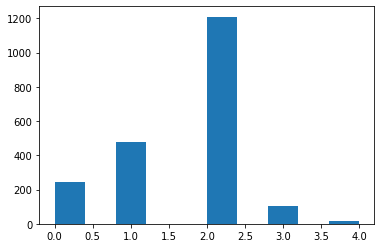

In [619]:
plt.hist(dissdf[2])

In [689]:
def make_list_of_diffs(dissdf,col_0_labels,col_1_labels):
    newlist = []
    for i in np.arange(0,len(dissdf)):
        print(i)
        oldi = dissdf[0][i]
        oldj = dissdf[1][i]
        
        name0 = get_name_from_val(col_0_labels,overlapping_list[oldi][0])
        print(name0)
        parent0 = get_hierarchy(col_0_labels,name0)

        name1 = get_name_from_val(col_1_labels,overlapping_list[oldi][1][oldj])
        print(name1)
        parent1 = get_hierarchy(col_1_labels,name1)
        
        newlist.append([oldi,name0,parent0,oldj,name1,parent1])
    return newlist
    

In [713]:
diss1 = dissdf[dissdf[2]==1].reset_index()
diss2 = dissdf[dissdf[2]==2].reset_index()
diss3 = dissdf[dissdf[2]==3].reset_index()
diss4 = dissdf[dissdf[2]==4].reset_index()
disshigh = dissdf[dissdf[2]>4].reset_index()

In [707]:
difflist = make_list_of_diffs(disshigh,lab_fischer,lab_sigma)

In [708]:
dfdiff = pd.DataFrame(difflist)

In [709]:
dfdiff.to_csv('/Users/emilydennis/Desktop/dfdiffhigh.csv')

In [714]:
# want to know the locations of overlap: how many voxels and where?

In [784]:
# where does A == a and B == b?
def get_voxel_coords(volA, indexA, volB, indexB):
    mA = volA==overlapping_list[indexA][0]
    mB = volB==overlapping_list[indexA][1][indexB]
    mC = mA*mB
    return np.nonzero(mC)

In [808]:
vx = get_voxel_coords(fischer,141,sigma,2)

In [820]:
val=20
print(vx[0][val],vx[1][val],vx[2][val])

586 354 315


In [832]:
get_name_from_val(lab_fischer,96)

'cortex'

In [835]:
lab_sigma[lab_sigma.ID> 140]

,atlas,ID,name,praid,parent
26,waxholm,141.0,entorhinal_cortex,3012.0,retrohippocampal
27,waxholm,142.0,entorhinal_cortex,3012.0,retrohippocampal
28,waxholm,151.0,fasciola_cinereum,3000.0,hippocampal_formation
29,waxholm,152.0,fasciola_cinereum,3000.0,hippocampal_formation
30,tohoku,161.0,frontal_association_cortex,1130.0,frontal_pole
...,...,...,...,...,...
229,waxholm,1152.0,ventral_hippocampal_commissure,12000.0,medial_forebrain_bundle
230,waxholm,1161.0,periventricular_grey,9110.0,thalamus
231,waxholm,1162.0,periventricular_grey,9110.0,thalamus
232,sigma,1171.0,ventricular_system,13000.0,ventricles
